In [10]:
### Loading Libraries
library(dplyr)
library(readr)
library(stringr)
library(lubridate)
library(ggplot2)
library(tidyr)
library(lfe)

In [11]:
### Loading Data
fp <- '/nfs/sloanlab004/projects/covid_mobility_proj/data/'
load(str_c(fp, 'PROCESSED_DATA/county_mobility_dvs.Rdata'))
safegraph     <- read_csv(str_c(fp, 'PROCESSED_DATA/safegraph_social_distancing_aggregate_county.csv'))
counties_long <- read_csv(str_c(fp, 'PROCESSED_DATA/county_policy_long.csv'))
countyInfo    <- read_csv(str_c(fp, 'PROCESSED_DATA/countyInfo.csv'))

Parsed with column specification:
cols(
  county_fips = col_double(),
  device_count = col_double(),
  completely_home_device_count = col_double(),
  part_time_work_behavior_devices = col_double(),
  full_time_work_behavior_devices = col_double(),
  ds = col_date(format = "")
)

Parsed with column specification:
cols(
  fips = col_double(),
  name = col_character(),
  state_abbv = col_character(),
  type = col_character(),
  dt = col_date(format = "")
)

Parsed with column specification:
cols(
  county_fips = col_double(),
  county_name = col_character(),
  state_abbv = col_character(),
  long = col_double(),
  lat = col_double()
)



In [12]:
counties_long %>% 
    mutate(value = 1) %>%
    spread(key = type, value = value) -> countyPolicy

safegraph %>%
    arrange(county_fips, ds) %>%
    mutate(sg_nhd = 1 - completely_home_device_count/device_count) %>%
    inner_join(countyInfo %>% select(-county_name)) %>%
    select(ds, county_fips, sg_nhd, state_abbv) %>%
    left_join(countyPolicy, by = c('ds' = 'dt', 'county_fips' = 'fips', 'state_abbv')) %>%
    group_by(county_fips) %>%
    arrange(county_fips, ds) %>%
    fill(gatherings50, gatherings500, gyms_movies, restaurants, schools, stay_home) %>%
    replace_na(list(gatherings50 = 0, gatherings500 = 0, 
                    gyms_movies = 0, restaurants = 0, 
                    schools = 0, stay_home = 0)) %>%
    filter(ds <= as.Date('2020-04-18')) %>% 
    left_join(county_mobility_dvs, by = c('county_fips' = 'origin_county', 'ds')) %>%
    mutate(sg_mcbgv       = (non_home_cbg_visits_within_county + cbg_visits_outside_county + home_cbg_visits)/device_count) -> df

Joining, by = "county_fips"



In [13]:
### Visualizing parallel trends
df %>%
    mutate(stay_home) %>%
    group_by(county_fips) %>%
    summarize(score = sum(stay_home)) %>%
    mutate(grp = ntile(score, 4)) %>%
    select(-score) %>%
    left_join(df) -> df

Joining, by = "county_fips"



Warning message:
“The labeller API has been updated. Labellers taking `variable` and `value` arguments are now deprecated. See labellers documentation.”


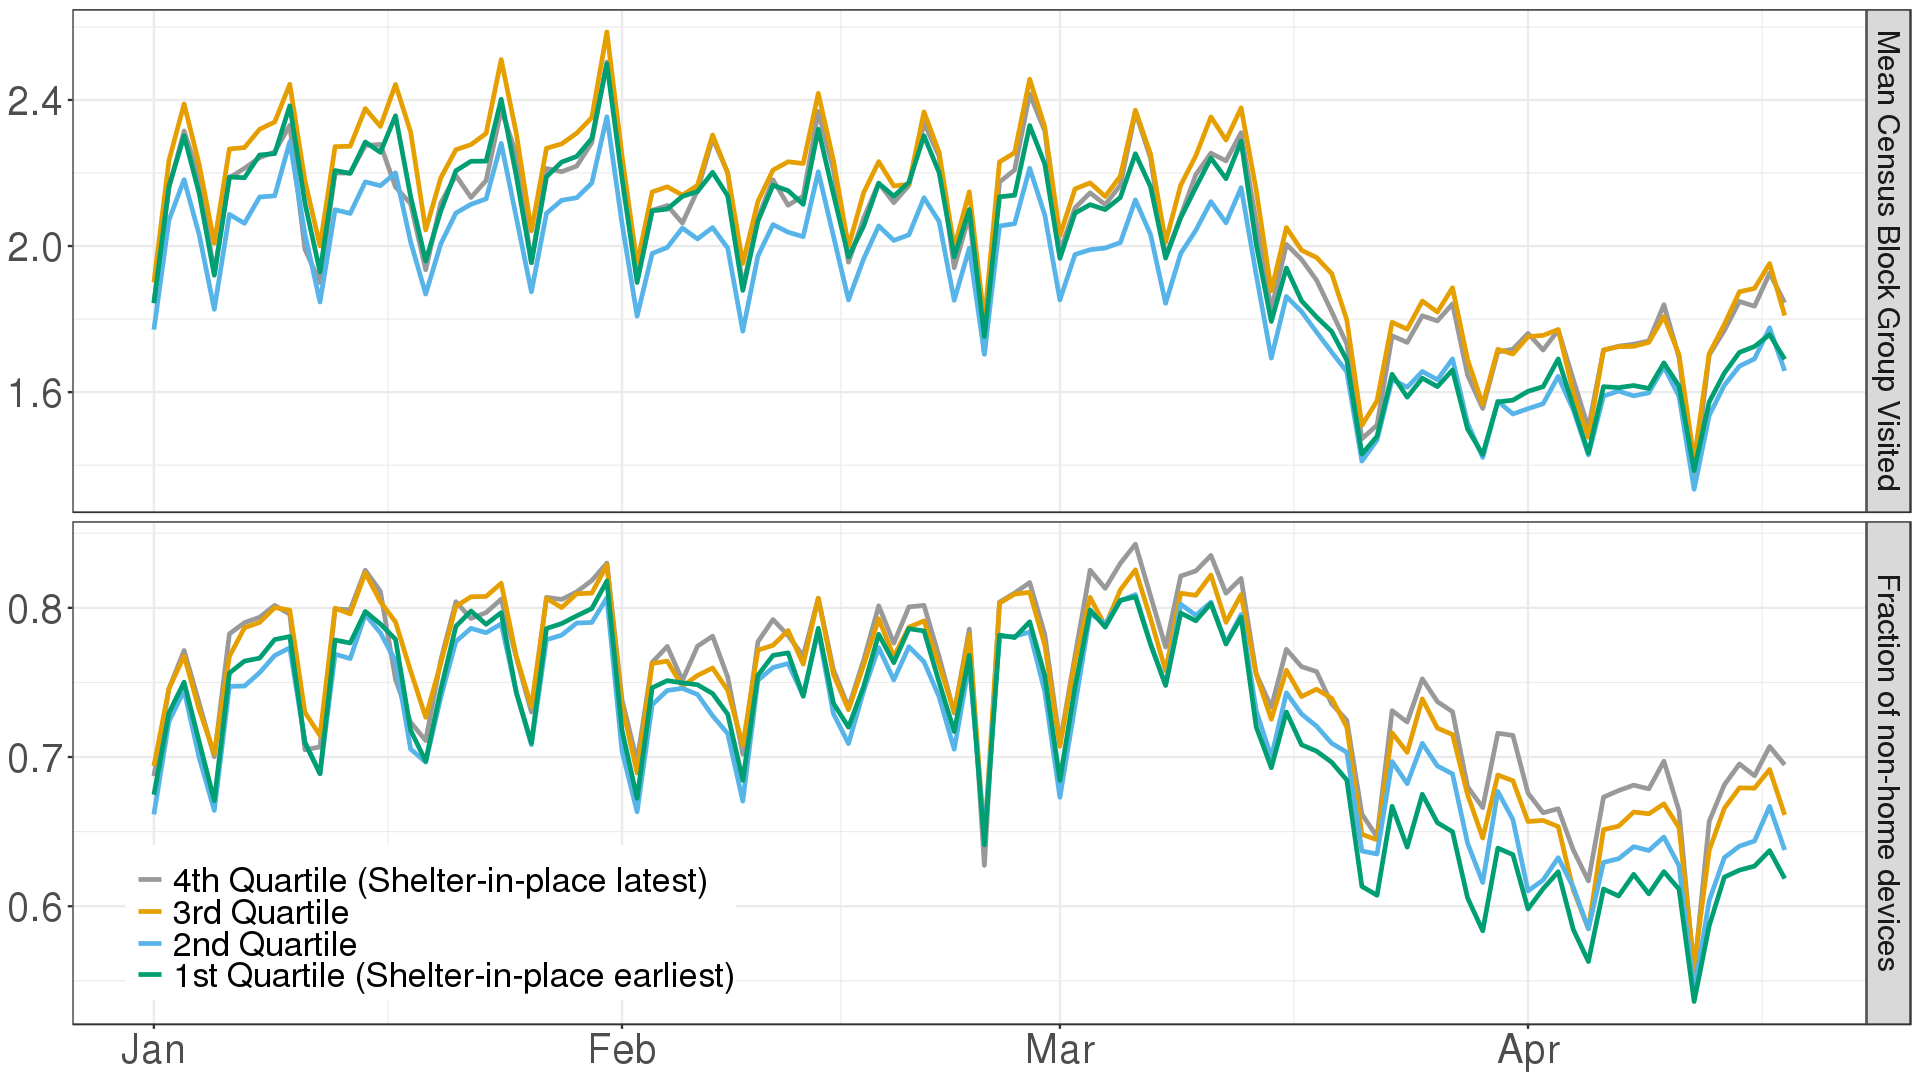

In [82]:
var_names <- list(
  'sg_nhd'="Fraction of non-home devices",
  'sg_mcbgv'="Mean Census Block Group Visited" 
) 

var_labeller <- function(variable,value){
  return(var_names[value])
}


options(repr.plot.width=16, repr.plot.height=9)
df %>%
    group_by(grp, ds) %>%
    summarize(sg_nhd = mean(sg_nhd),
              sg_mcbgv = mean(sg_mcbgv)) %>%
    gather(key = 'var', value = 'value', sg_nhd, sg_mcbgv) %>%
    group_by(grp, ds) %>%
    ggplot(aes(x = ds, y = value, color = as.factor(grp))) +
    geom_line(size = 1) +
    theme_bw()+ theme(axis.text=element_text(size=24),
        axis.title=element_blank())+
    scale_colour_manual(values=c("#999999", "#E69F00", "#56B4E9", "#009E73"),breaks=c("1", "2", "3","4"), labels=c("4th Quartile (Shelter-in-place latest)", "3rd Quartile","2nd Quartile","1st Quartile (Shelter-in-place earliest)"))+   
    facet_grid(var ~ ., scales = 'free',labeller = var_labeller) +
    theme(strip.text.y = element_text(size = 18))+
     theme(legend.position = c(0.2, 0.1))+
    theme(legend.title = element_blank())+
    theme(legend.text=element_text(size=20))
    